### Application: A Face Detection Pipeline

• This chapter has explored a number of the central concepts and algorithms of machine learning.

• But moving from these concepts to real-world application can be a challenge.

• Real-world datasets are noisy and heterogeneous, may have missing features, and data may be in a form that is difficult to map to a clean [n_samples, n_features] matrix.

• Before applying any of the methods discussed here, you must first extract these features from your data: there is no formula for how to do this that applies across all domains, and thus this is where you as a data scientist must exercise your own intuition and expertise.

• One interesting and compelling application of machine learning is to images, and we have already seen a few examples of this where pixel-level features are used for classification.

• In the real world, data is rarely so uniform and simple pixels will not be suitable: this has led to a large literature on feature extraction methods for image data (see Feature Engineering).

• In this section, we will take a look at one such feature extraction technique, the Histogram of Oriented Gradients (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.

• We will use these features to develop a simple face detection pipeline, using machine learning algorithms and concepts we've seen throughout this chapter.

• We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

### HOG Features

• The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.

• HOG involves the following steps:

    1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.

    2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.

    3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.

    4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.

    5. Construct a one-dimensional feature vector from the information in each cell.

• A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

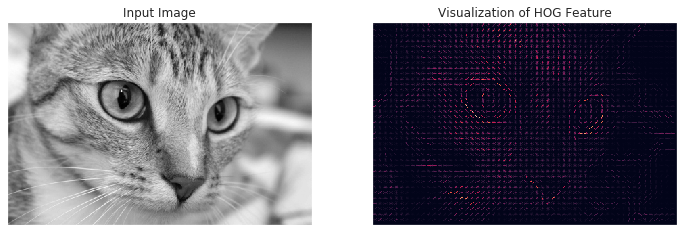

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                      subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input Image')

ax[1].imshow(hog_vis)
ax[1].set_title('Visualization of HOG Feature');

### HOG in Action: A Simple Face Detector

• Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine (refer back to In-Depth: Support Vector Machines if you need a refresher on this).

• The steps are as follows:

    1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
    
    2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
    
    3. Extract HOG features from these training samples.

    4. Train a linear SVM classifier on these samples.
    
    5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.

    6. If detections overlap, combine them into a single window.
    
• Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples

• Let's start by finding some positive training samples that show a variety of faces.

• We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

• This gives us a sample of 13,000 face images to use for training.

### 2. Obtain a set of negative training samples

• Next we need a set of similarly sized thumbnails which do not have a face in them.

• One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.

• Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's PatchExtractor:

In [4]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
              'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
         for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

• We now have 30,000 suitable image patches which do not contain faces.

• Let's take a look at a few of them to get an idea of what they look like:

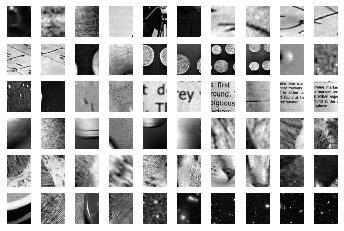

In [6]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

• Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

• Now that we have these positive samples and negative samples, we can combine them and compute HOG features.

• This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [8]:
from itertools import chain
X_train = np.array([feature.hog(im)
                  for im in chain(positive_patches,
                                 negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

• We are left with 43,000 training samples in 1,215 dimensions, and we now have our data in a form that we can feed into Scikit-Learn!

### 4. Training a support vector machine

• Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.

• For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.

• We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

• First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train, cv = 5)

array([0.94784318, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

• We see that on our training data, even a simple naive Bayes algorithm gets us upwards of 90% accuracy.

• Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [31]:
import warnings

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]}, cv = 5)
grid.fit(X_train, y_train)
grid.best_score_

/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rajesh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

0.9884347604838897

In [32]:
grid.best_params_

{'C': 1.0}

• Let's take the best estimator and re-train it on the full dataset:

In [33]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 5. Find faces in a new image

• Now that we have this model in place, let's grab a new image and see how the model does.

• We will use one portion of the astronaut image for simplicity (see discussion of this in Caveats and Improvements), and run a sliding window over it and evaluate each patch:

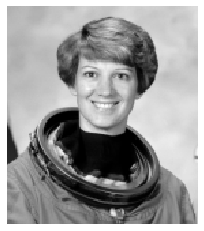

In [35]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

• Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [36]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patces_hog = np.array([feature.hog(patch) for patch in patches])
patces_hog.shape

(1911, 1215)

• Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [37]:
labels = model.predict(patces_hog)
labels.sum()

49.0

• We see that out of nearly 2,000 patches, we have found 30 detections.

• Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

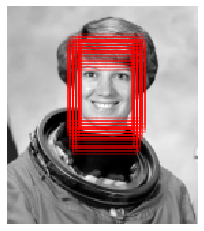

In [38]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap = 'gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                              alpha=0.3, lw=2, facecolor='none'))

• All of the detected patches overlap and found the face in the image! Not bad for a few lines of Python.

### Caveats and Improvements

• If you dig a bit deeper into the preceding code and examples, you'll see that we still have a bit of work before we can claim a production-ready face detector. There are several issues with what we've done, and several improvements that could be made.

• In particular:

### Our training set, especially for negative features, is not very complete

• The central issue is that there are many face-like textures that are not in the training set, and so our current model is very prone to false positives.

• You can see this if you try out the above algorithm on the full astronaut image: the current model leads to many false detections in other regions of the image.

• We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement.

• Another way to address this is to use a more directed approach, such as hard negative mining.

• In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

### Our current pipeline searches only at one scale

• As currently written, our algorithm will miss faces that are not approximately 62×47 pixels.

• This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using skimage.transform.resize before feeding it into the model.

• In fact, the sliding_window() utility used here is already built with this in mind.

### We should combine overlapped detection patches

• For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection.

• This could be done via an unsupervised clustering approach (MeanShift Clustering is one good candidate for this), or via a procedural approach such as non-maximum suppression, an algorithm common in machine vision.

### The pipeline should be streamlined

• Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.

• This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily.

• I will leave this as a proverbial "exercise for the reader".

### More recent advances: Deep Learning

• Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.

• Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.

• An intro to these deep neural net methods is conceptually (and computationally!) beyond the scope of this section, although open tools like Google's TensorFlow have recently made deep learning approaches much more accessible than they once were.

• As of the writing of this book, deep learning in Python is still relatively young, and so I can't yet point to any definitive resource.

• That said, the list of references in the following section should provide a useful place to start!